# CE-40717: Machine Learning

## HW8-Clustering & Reinforcement Learning

### Kmeans & GMM:

At this question, we tend to implement Kmeans & GMM algorithms. For this purpose, `DO NOT EMPLOY` ready-for-use python libraries. Use this implementation for solving the following questions. Kmeans should continue till centeroids won't change. Furthermore, GMM also should continue till the difference of two consecutive likelihood logarithm would be less than 0.1. Notice that after executing the Kmeans part, the primitive centroids of GMM should be identical with ultimate Kmeans centroids.

In [43]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
from scipy.stats import multivariate_normal
import math
import random
import matplotlib.colors as c
import scipy.stats as sp
import pandas as pd

In [33]:
from sklearn.datasets.samples_generator import make_classification, make_moons, make_circles

#### Part 1:

Utilize the subsequent cell in order to create the Dataset. Afterwards, try to execute the algorithm with k=2 centroids. At Kmeans, it is recommended to execute the algorithm with several various starting states in order to eventually choose the best respective result.

In [58]:
X,Y = make_classification(n_samples=700, n_features=10, n_informative=5,
                          n_redundant=0, n_clusters_per_class=2, n_classes=3)

In [35]:
class KMeans:

    def __init__(self, n_clusters = 3, tolerance = 0.01, max_iter = 100, runs = 1):
        self.n_clusters = n_clusters
        self.tolerance = tolerance
        self.cluster_means = np.zeros(n_clusters)
        self.max_iter = max_iter
        self.runs = runs
        
    def fit(self, X,Y):
        row_count, col_count = X.shape
        
        X_values = self.__get_values(X)
        
        X_labels = np.zeros(row_count)
        
        costs = np.zeros(self.runs)
        all_clusterings = []

        for i in range(self.runs):
            cluster_means =  self.__initialize_means(X_values, row_count)

            for _ in range(self.max_iter):            
                previous_means = np.copy(cluster_means)
                
                distances = self.__compute_distances(X_values, cluster_means, row_count)
            
                X_labels = self.__label_examples(distances)
            
                cluster_means = self.__compute_means(X_values, X_labels, col_count)

                clusters_not_changed = np.abs(cluster_means - previous_means) < self.tolerance
                if np.all(clusters_not_changed) != False:
                    break
            
            X_values_with_labels = np.append(X_values, X_labels[:, np.newaxis], axis = 1)
            
            all_clusterings.append( (cluster_means, X_values_with_labels) )
            costs[i] = self.__compute_cost(X_values, X_labels, cluster_means)
        
        best_clustering_index = costs.argmin()
        
        self.costs = costs
        self.cost_ = costs[best_clustering_index]
        
        self.centroid,self.items = all_clusterings[best_clustering_index]
        self.y = Y
        return all_clusterings[best_clustering_index]
        
    def __initialize_means(self, X, row_count):
        return X [ np.random.choice(row_count, size=self.n_clusters, replace=False) ]
        
        
    def __compute_distances(self, X, cluster_means, row_count):
        distances = np.zeros((row_count, self.n_clusters))
        for cluster_mean_index, cluster_mean in enumerate(cluster_means):
            distances[:, cluster_mean_index] = np.linalg.norm(X - cluster_mean, axis = 1)
            
        return distances
    
    def __label_examples(self, distances):
        return distances.argmin(axis = 1)
    
    def __compute_means(self, X, labels, col_count):
        cluster_means = np.zeros((self.n_clusters, col_count))
        for cluster_mean_index, _ in enumerate(cluster_means):
            cluster_elements = X [ labels == cluster_mean_index ]
            if len(cluster_elements):
                cluster_means[cluster_mean_index, :] = cluster_elements.mean(axis = 0)
                
        return cluster_means
    
    def __compute_cost(self, X, labels, cluster_means):
        cost = 0
        for cluster_mean_index, cluster_mean in enumerate(cluster_means):
            cluster_elements = X [ labels == cluster_mean_index ]
            cost += np.linalg.norm(cluster_elements - cluster_mean, axis = 1).sum()
        
        return cost
            
    def __get_values(self, X):
        if isinstance(X, np.ndarray):
            return X
        return np.array(X)
    
    def predict(self):
        data=pd.DataFrame(self.items)
        added_column=list(data.columns)[-1]
        data['Label'] = self.y
        resultOfClustering=data.groupby([added_column])['Label'].agg(lambda x: x.value_counts().index[0])
        mapping = dict()
        for label in range(self.n_clusters):
            label_predicted = resultOfClustering[label]
            mapping[label] = label_predicted
        data['PredictedLabels']=data[added_column].map(mapping)
        return np.array(data['PredictedLabels'])

In [36]:
class GaussianMixModel():
    def __init__(self, X, k=2):
        X = np.asarray(X)
        self.m, self.n = X.shape
        self.data = X.copy()
        self.k = k
        
        self.sigma_arr = np.array([np.asmatrix(np.identity(self.n)) for i in range(self.k)])
        self.phi = np.ones(self.k)/self.k
        self.Z = np.asmatrix(np.empty((self.m, self.k), dtype=float))

     
    def initialize_means(self,means):
        self.mean_arr = means
    
    def fit(self, tol=0.1):

        num_iters = 0
        logl = 1
        previous_logl = 0
        while(logl-previous_logl > tol):
            previous_logl = self.loglikelihood()
            self.e_step()
            self.m_step()
            num_iters += 1
            logl = self.loglikelihood()
            print('Iteration %d: log-likelihood is %.6f'%(num_iters, logl))
        print('Terminate at %d-th iteration:log-likelihood is %.6f'%(num_iters, logl))

    def loglikelihood(self):
        logl = 0
        for i in range(self.m):
            tmp = 0
            for j in range(self.k):
                tmp += sp.multivariate_normal.pdf(self.data[i, :],self.mean_arr[j, :].A1,self.sigma_arr[j, :]) * self.phi[j]
            logl += np.log(tmp)
        return logl


    def e_step(self):
        for i in range(self.m):
            den = 0
            for j in range(self.k):
                num = sp.multivariate_normal.pdf(self.data[i, :],
                                                       self.mean_arr[j].A1,
                                                       self.sigma_arr[j]) *\
                      self.phi[j]
                den += num

                self.Z[i, j] = num
            self.Z[i, :] /= den
            assert self.Z[i, :].sum() - 1 < 1e-4  # Program stop if this condition is false

    def m_step(self):
         for j in range(self.k):
            const = self.Z[:, j].sum()
            self.phi[j] = 1/self.m * const
            _mu_j = np.zeros(self.n)
            _sigma_j = np.zeros((self.n, self.n))
            for i in range(self.m):
                _mu_j += (self.data[i, :] * self.Z[i, j])
                _sigma_j += self.Z[i, j] * ((self.data[i, :] - self.mean_arr[j, :]).T * (self.data[i, :] - self.mean_arr[j, :]))

            self.mean_arr[j] = _mu_j / const
            self.sigma_arr[j] = _sigma_j / const
    
    def predict(self):
        return np.array(np.argmax(gmm.Z,axis=1)).flatten()

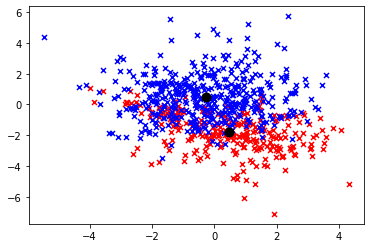

In [65]:
k=2
kmeans=KMeans(k,max_iter=10000,runs=20)
centroids,kmeans_items=kmeans.fit(X,Y)

color_s =["green","blue","navy","maroon",'orange'] 
for i in range(k):
    plt.scatter(kmeans_items[kmeans_items[:,2]==i,0] , kmeans_items[kmeans_items[:,2]==i,1] 
                ,s=100, label = "cluster "+str(i), color =color_s[i])

plt.scatter(centroids[:,0] , centroids[:,1] , s = 300, color = 'red')
plt.title('Our clusters')
plt.show();

Iteration 1: log-likelihood is -11265.599054
Iteration 2: log-likelihood is -11245.662340
Iteration 3: log-likelihood is -11234.739960
Iteration 4: log-likelihood is -11227.816418
Iteration 5: log-likelihood is -11223.045687
Iteration 6: log-likelihood is -11219.274141
Iteration 7: log-likelihood is -11215.720434
Iteration 8: log-likelihood is -11211.761311
Iteration 9: log-likelihood is -11206.775492
Iteration 10: log-likelihood is -11199.651704
Iteration 11: log-likelihood is -11189.159973
Iteration 12: log-likelihood is -11177.798455
Iteration 13: log-likelihood is -11169.785729
Iteration 14: log-likelihood is -11165.241860
Iteration 15: log-likelihood is -11162.619469
Iteration 16: log-likelihood is -11161.034193
Iteration 17: log-likelihood is -11160.045999
Iteration 18: log-likelihood is -11159.334026
Iteration 19: log-likelihood is -11158.729273
Iteration 20: log-likelihood is -11158.149612
Iteration 21: log-likelihood is -11157.552756
Iteration 22: log-likelihood is -11156.9192

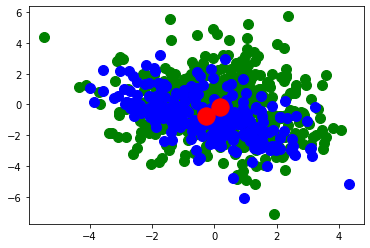

In [66]:
gmm=GaussianMixModel(X,k=2)
gmm.initialize_means(np.asmatrix(centroids))
gmm.fit()
gmm_result = gmm.predict()
data=pd.DataFrame(X)
data['Predicted'] = gmm_result

for i in range(k):
    plt.scatter(data[data['Predicted']==i][0], data[data['Predicted']==i][1]
                ,s=100, label = "cluster "+str(i), color =color_s[i])

plt.scatter(np.array(gmm.mean_arr[:,0]).flatten() , np.array(gmm.mean_arr[:,1]).flatten() , s = 300, color = 'red')
plt.show();

#### Part 2:

In a separated cell, implement `Purity` and `Rand-Index` criteria in order to compare the performance of mentioned algorithms.

In [39]:
from sklearn import metrics
def purity_score(y_true, y_pred):
    contingency_matrix = metrics.cluster.contingency_matrix(y_true, y_pred)
    return np.sum(np.amax(contingency_matrix, axis=0)) / np.sum(contingency_matrix)

In [40]:
from scipy.special import comb
def rand_index_score(clusters, classes):
    tp_plus_fp = comb(np.bincount(clusters), 2).sum()
    tp_plus_fn = comb(np.bincount(classes), 2).sum()
    A = np.c_[(clusters, classes)]
    tp = sum(comb(np.bincount(A[A[:, 0] == i, 1]), 2).sum()
             for i in set(clusters))
    fp = tp_plus_fp - tp
    fn = tp_plus_fn - tp
    tn = comb(len(A), 2) - tp - fp - fn
    return (tp + tn) / (tp + fp + fn + tn)

In [44]:
print('Purity Of kmeans: ',purity_score(Y,kmeans.predict()))

Purity Of kmeans:  0.46285714285714286


In [45]:
print('Purity Of GMM: ',purity_score(Y,gmm.predict()))

Purity Of GMM:  0.49142857142857144


In [46]:
print('Rand-index Of kmeans: ',rand_index_score(kmeans.predict(),Y))

Rand-index Of kmeans:  0.5331943592887799


In [48]:
print('Rand-index Of kmeans: ',rand_index_score(gmm.predict(),Y))

Rand-index Of kmeans:  0.5413243408951564


#### Part 3:

Use the following cell in order to create new Datasets. Afterwards, try to execute mentioned algorithms on new Dataset and eventually compare the recent results with the help of visualization(there is no problem for using relevant python libraries like `matplotlib`). Consider two clusters for this part.

In [49]:
X, Y = make_classification(n_samples=700, n_features=2, n_informative=2, n_redundant=0, n_classes=2)

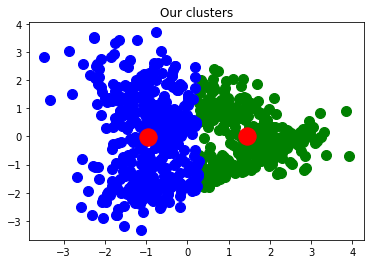

In [50]:
k=2
kmeans=KMeans(k,max_iter=10000,runs=20)
centroids,kmeans_items=kmeans.fit(X,Y)

color_s =["green","blue","navy","maroon",'orange'] 
for i in range(k):
    plt.scatter(kmeans_items[kmeans_items[:,2]==i,0] , kmeans_items[kmeans_items[:,2]==i,1] 
                ,s=100, label = "cluster "+str(i), color =color_s[i])

plt.scatter(centroids[:,0] , centroids[:,1] , s = 300, color = 'red')
plt.title('Our clusters')
plt.show();

Iteration 1: log-likelihood is -2348.282422
Iteration 2: log-likelihood is -2344.598753
Iteration 3: log-likelihood is -2343.742134
Iteration 4: log-likelihood is -2343.318686
Iteration 5: log-likelihood is -2343.051634
Iteration 6: log-likelihood is -2342.863406
Iteration 7: log-likelihood is -2342.720008
Iteration 8: log-likelihood is -2342.604595
Iteration 9: log-likelihood is -2342.508060
Terminate at 9-th iteration:log-likelihood is -2342.508060


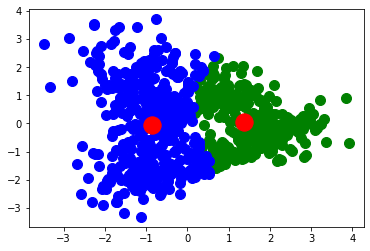

In [51]:
gmm=GaussianMixModel(X,k)
gmm.initialize_means(np.asmatrix(centroids))
gmm.fit();
gmm_result = gmm.predict()
data=pd.DataFrame(X)
data['Predicted'] = gmm_result

for i in range(k):
    plt.scatter(data[data['Predicted']==i][0], data[data['Predicted']==i][1]
                ,s=100, label = "cluster "+str(i), color =color_s[i])

plt.scatter(np.array(gmm.mean_arr[:,0]).flatten() , np.array(gmm.mean_arr[:,1]).flatten() , s = 300, color = 'red')
plt.show();

In [52]:
X, Y = make_moons(n_samples=700, noise=0.2)

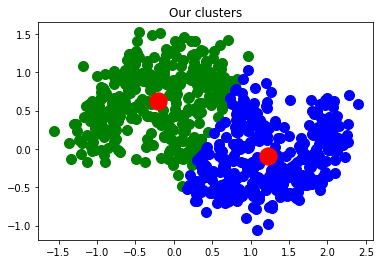

In [53]:
k=2
kmeans=KMeans(k,max_iter=10000,runs=20)
centroids,kmeans_items=kmeans.fit(X,Y)

color_s =["green","blue","navy","maroon",'orange'] 
for i in range(k):
    plt.scatter(kmeans_items[kmeans_items[:,2]==i,0] , kmeans_items[kmeans_items[:,2]==i,1] 
                ,s=100, label = "cluster "+str(i), color =color_s[i])

plt.scatter(centroids[:,0] , centroids[:,1] , s = 300, color = 'red')
plt.title('Our clusters')
plt.show();

Iteration 1: log-likelihood is -1420.783530
Iteration 2: log-likelihood is -1414.805839
Iteration 3: log-likelihood is -1407.896756
Iteration 4: log-likelihood is -1396.602205
Iteration 5: log-likelihood is -1379.619056
Iteration 6: log-likelihood is -1359.261821
Iteration 7: log-likelihood is -1343.551563
Iteration 8: log-likelihood is -1337.090987
Iteration 9: log-likelihood is -1335.643416
Iteration 10: log-likelihood is -1335.401701
Iteration 11: log-likelihood is -1335.352026
Terminate at 11-th iteration:log-likelihood is -1335.352026


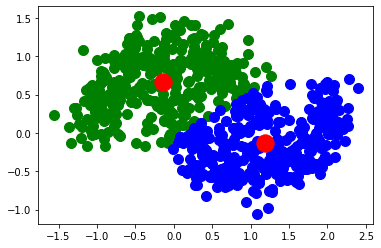

In [54]:
gmm=GaussianMixModel(X,k)
gmm.initialize_means(np.asmatrix(centroids))
gmm.fit();
gmm_result = gmm.predict()
data=pd.DataFrame(X)
data['Predicted'] = gmm_result

for i in range(k):
    plt.scatter(data[data['Predicted']==i][0], data[data['Predicted']==i][1]
                ,s=100, label = "cluster "+str(i), color =color_s[i])

plt.scatter(np.array(gmm.mean_arr[:,0]).flatten() , np.array(gmm.mean_arr[:,1]).flatten() , s = 300, color = 'red')
plt.show();

In [55]:
X, Y = make_circles(n_samples=700, noise=0.2)

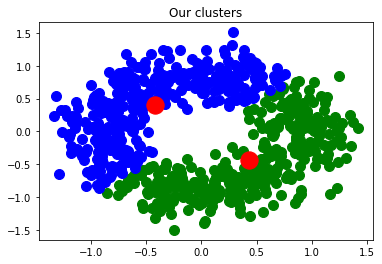

In [56]:
k=2
kmeans=KMeans(k,max_iter=10000,runs=20)
centroids,kmeans_items=kmeans.fit(X,Y)

color_s =["green","blue","navy","maroon",'orange'] 
for i in range(k):
    plt.scatter(kmeans_items[kmeans_items[:,2]==i,0] , kmeans_items[kmeans_items[:,2]==i,1] 
                ,s=100, label = "cluster "+str(i), color =color_s[i])

plt.scatter(centroids[:,0] , centroids[:,1] , s = 300, color = 'red')
plt.title('Our clusters')
plt.show();

Iteration 1: log-likelihood is -1432.220704
Iteration 2: log-likelihood is -1422.686362
Iteration 3: log-likelihood is -1422.560679
Iteration 4: log-likelihood is -1422.407616
Iteration 5: log-likelihood is -1422.213068
Iteration 6: log-likelihood is -1421.961045
Iteration 7: log-likelihood is -1421.627801
Iteration 8: log-likelihood is -1421.176881
Iteration 9: log-likelihood is -1420.550539
Iteration 10: log-likelihood is -1419.654287
Iteration 11: log-likelihood is -1418.328308
Iteration 12: log-likelihood is -1416.293766
Iteration 13: log-likelihood is -1413.053617
Iteration 14: log-likelihood is -1407.727461
Iteration 15: log-likelihood is -1398.880439
Iteration 16: log-likelihood is -1384.845105
Iteration 17: log-likelihood is -1366.065776
Iteration 18: log-likelihood is -1349.004291
Iteration 19: log-likelihood is -1340.770420
Iteration 20: log-likelihood is -1338.782127
Iteration 21: log-likelihood is -1338.419365
Iteration 22: log-likelihood is -1338.295787
Iteration 23: log-l

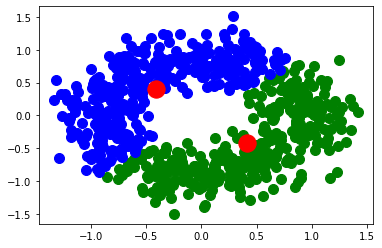

In [57]:
gmm=GaussianMixModel(X,k)
gmm.initialize_means(np.asmatrix(centroids))
gmm.fit();
gmm_result = gmm.predict()
data=pd.DataFrame(X)
data['Predicted'] = gmm_result

for i in range(k):
    plt.scatter(data[data['Predicted']==i][0], data[data['Predicted']==i][1]
                ,s=100, label = "cluster "+str(i), color =color_s[i])

plt.scatter(np.array(gmm.mean_arr[:,0]).flatten() , np.array(gmm.mean_arr[:,1]).flatten() , s = 300, color = 'red')
plt.show();

### Reinforcement Learning:

At the bellow cell, besides the required libraries have been imported, feel free for changing the num_states variable with your desired number.

In [2]:
import numpy as np
import random
import gym

In [4]:
env = gym.make("MountainCar-v0")
num_actions = 3
q_table =  np.zeros((40, 40, num_actions))

In [5]:
N_EPISODES = 5000
INITIAL_LR = 1.0 
MIN_LR = 0.003
T_MAX = 10000
EPS = 0.1
N_STATES = 40
GAMMA = 0.95

#### Part 1:

Next cell wants you supplement two functions. First for transforming the continuous space into discrete one (in order to make using q_table feasible), second for updating q_values based on the last action done by agent.

In [6]:
def discretize_state(x, minn, step):
    return (x - minn) / step

def env_state_to_Q_state(env, obs):
    l_env = env.observation_space.low
    h_env = env.observation_space.high
    env_dx = discretize_state(h_env, l_env, N_STATES)
    a = int((obs[0] - l_env[0])/env_dx[0])
    b = int((obs[1] - l_env[1])/env_dx[1])
    return a, b

def update_q(a, b, a_, b_, action, eta, reward):
    q_table[a][b][action] = q_table[a][b][action] + eta * (reward + GAMMA *  np.max(q_table[a_][b_]) - q_table[a][b][action])

#### Part 2:

At the following cell, the ends of two functions are getting current action based on the policy and defining the training process respectively.

In [7]:
def get_action():
    for i in range(N_EPISODES):
        obs = env.reset()
        total_reward = 0
        eta = max(MIN_LR, INITIAL_LR * (0.85 ** (i//100)))
        for j in range(T_MAX):
            a, b = env_state_to_Q_state(env, obs)
            if np.random.uniform(0, 1) < EPS:
                action = np.random.choice(env.action_space.n) 
            else:
                action = np.argmax(q_table[a][b])
            obs, reward, done, _ = env.step(action)
            total_reward += reward

            a_, b_ = env_state_to_Q_state(env, obs)
            update_q(a, b, a_, b_, action, eta, reward)

            if done:
                break

        if i % 1000 == 0 and i !=0:
            print(f'Episode {i} : Reward = {total_reward}')

def q_learning():
    solution_policy = np.argmax(q_table, axis=2) 
    return solution_policy   

def save_policy():
    policy = q_learning()
    np.save('policy.npy', policy)

In [8]:
get_action()
save_policy()

Episode 1000 : Reward = -164.0
Episode 2000 : Reward = -155.0
Episode 3000 : Reward = -200.0
Episode 4000 : Reward = -191.0


#### Part 3:

Ultimately, the score function examines the average performance of Agent (after nearly 1000 times) based on previous implementations.

In [9]:
def score():
    policy, scores = np.load("policy.npy"), []
    for episode in range(1000):
        print(f"******Episode {episode}")
        state, score, done, step = env_state_to_Q_state(env,env.reset()), 0, False, 0
        while not done:
            action = policy[state]
            state, reward, done, _ = env.step(action)
            state = env_state_to_Q_state(env,state)
            step += 1
            score += int(reward)
            env.render()
        print(f"Score:{score}")
        scores.append(score)
    print(f"Average score over 1000 run : {np.array(scores).mean()}")

score()

******Episode 0
Score:-159
******Episode 1
Score:-198
******Episode 2
Score:-162
******Episode 3
Score:-161
******Episode 4
Score:-132
******Episode 5
Score:-198
******Episode 6
Score:-162
******Episode 7
Score:-191
******Episode 8
Score:-164
******Episode 9
Score:-180
******Episode 10
Score:-166
******Episode 11
Score:-199
******Episode 12
Score:-193
******Episode 13
Score:-162
******Episode 14
Score:-192
******Episode 15
Score:-161
******Episode 16
Score:-120
******Episode 17
Score:-159
******Episode 18
Score:-194
******Episode 19
Score:-167
******Episode 20
Score:-158
******Episode 21
Score:-165
******Episode 22
Score:-156
******Episode 23
Score:-197
******Episode 24
Score:-159
******Episode 25
Score:-157
******Episode 26
Score:-162
******Episode 27
Score:-196
******Episode 28
Score:-198
******Episode 29
Score:-190
******Episode 30
Score:-194
******Episode 31
Score:-169
******Episode 32
Score:-197
******Episode 33
Score:-198
******Episode 34
Score:-157
******Episode 35
Score:-198
**

Score:-162
******Episode 287
Score:-158
******Episode 288
Score:-192
******Episode 289
Score:-156
******Episode 290
Score:-190
******Episode 291
Score:-175
******Episode 292
Score:-192
******Episode 293
Score:-160
******Episode 294
Score:-165
******Episode 295
Score:-177
******Episode 296
Score:-192
******Episode 297
Score:-175
******Episode 298
Score:-198
******Episode 299
Score:-157
******Episode 300
Score:-192
******Episode 301
Score:-157
******Episode 302
Score:-199
******Episode 303
Score:-192
******Episode 304
Score:-176
******Episode 305
Score:-191
******Episode 306
Score:-121
******Episode 307
Score:-194
******Episode 308
Score:-161
******Episode 309
Score:-162
******Episode 310
Score:-161
******Episode 311
Score:-194
******Episode 312
Score:-196
******Episode 313
Score:-165
******Episode 314
Score:-192
******Episode 315
Score:-197
******Episode 316
Score:-164
******Episode 317
Score:-162
******Episode 318
Score:-164
******Episode 319
Score:-198
******Episode 320
Score:-162
***

Score:-170
******Episode 570
Score:-159
******Episode 571
Score:-181
******Episode 572
Score:-131
******Episode 573
Score:-192
******Episode 574
Score:-166
******Episode 575
Score:-169
******Episode 576
Score:-191
******Episode 577
Score:-181
******Episode 578
Score:-167
******Episode 579
Score:-157
******Episode 580
Score:-192
******Episode 581
Score:-174
******Episode 582
Score:-198
******Episode 583
Score:-194
******Episode 584
Score:-170
******Episode 585
Score:-172
******Episode 586
Score:-197
******Episode 587
Score:-160
******Episode 588
Score:-160
******Episode 589
Score:-122
******Episode 590
Score:-159
******Episode 591
Score:-131
******Episode 592
Score:-183
******Episode 593
Score:-160
******Episode 594
Score:-198
******Episode 595
Score:-165
******Episode 596
Score:-164
******Episode 597
Score:-200
******Episode 598
Score:-156
******Episode 599
Score:-192
******Episode 600
Score:-192
******Episode 601
Score:-132
******Episode 602
Score:-140
******Episode 603
Score:-158
***

Score:-162
******Episode 853
Score:-180
******Episode 854
Score:-163
******Episode 855
Score:-192
******Episode 856
Score:-119
******Episode 857
Score:-162
******Episode 858
Score:-170
******Episode 859
Score:-192
******Episode 860
Score:-164
******Episode 861
Score:-162
******Episode 862
Score:-158
******Episode 863
Score:-198
******Episode 864
Score:-165
******Episode 865
Score:-162
******Episode 866
Score:-185
******Episode 867
Score:-161
******Episode 868
Score:-200
******Episode 869
Score:-166
******Episode 870
Score:-197
******Episode 871
Score:-181
******Episode 872
Score:-169
******Episode 873
Score:-194
******Episode 874
Score:-131
******Episode 875
Score:-120
******Episode 876
Score:-156
******Episode 877
Score:-159
******Episode 878
Score:-163
******Episode 879
Score:-191
******Episode 880
Score:-176
******Episode 881
Score:-157
******Episode 882
Score:-192
******Episode 883
Score:-198
******Episode 884
Score:-200
******Episode 885
Score:-197
******Episode 886
Score:-158
***